In [2]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import pickle

Queries = "topics-2014_2015-summary.topics"
Qrels = "qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

    
eval = trec.TrecEvaluation(cases, Qrels)
#print(cases.values())
vectorizerQueries = CountVectorizer(ngram_range=(1,1), analyzer = "word", stop_words = None)
YQueries = vectorizerQueries.fit_transform(cases.values())

print("Nr de pacientes (queries): " + str(len(cases)))


Nr de pacientes (queries): 60


## Separação das queries em 2 subsets (treino e teste)

In [3]:
import itertools
def splitDict(d):
    n = len(d) // 5        
    i = iter(d.items()) 

    d1 = dict(itertools.islice(i, n))
    d2 = dict(i)                        
    return d1, d2

#48 queries para treino, 12 para teste
casesTreino , casesTeste = splitDict(cases)

In [26]:

#Fazer load dos ficheiros de ensaios clinicos e ids
def loadFiles():
    docsGender = pickle.load( open( "./corpusBins/docGender.bin", "rb" ) )
    ids = pickle.load( open( "./corpusBins/docID.bin", "rb" ))
    docMaxAge = pickle.load( open( "./corpusBins/docMaxAge.bin", "rb" ) )
    docMinAge = pickle.load( open( "./corpusBins/docMinAge.bin", "rb" ) )
    docBriefSummary = pickle.load( open( "./corpusBins/docsBriefSummary.bin", "rb" ) )
    docsTitle = pickle.load( open( "./corpusBins/docsTitle.bin", "rb" ) )
    docsDetailed_Description = pickle.load( open( "./corpusBins/docsDetailed_Description.bin", "rb" ) )
    docCriteria = pickle.load( open( "./corpusBins/docCriteria.bin", "rb" ) )
    return docsGender,ids, docMaxAge, docMinAge, docBriefSummary, docsTitle, docsDetailed_Description, docCriteria
docsGender,ids, docMaxAge, docMinAge, docBriefSummary, docsTitle, docsDetailed_Description, docCriteria = loadFiles()

In [15]:
#Medias para todas as queries
def calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, nrCases, allRecalls=None):
    averageAllP10s = np.sum(allP10s)/nrCases
    averageAllMrr = np.sum(allMrr)/nrCases
    averageNdcg5 = np.sum(allNdcg5)/nrCases
    averageAp = np.sum(allAp)/nrCases
    if allRecalls:
        averageRecall = np.sum(allRecalls)/nrCases
        return averageAllP10s,averageAllMrr,averageNdcg5, averageAp, averageRecall
    return averageAllP10s,averageAllMrr,averageNdcg5, averageAp

In [16]:
def calculateLMJMValues(matrixTransformed):
    
    #Somar na vertical
    termFreq = matrixTransformed.sum(axis=0)
    #Somar na horizontal
    docLen = matrixTransformed.sum(axis=1)
    #tamanho total do corpus
    lenTotal = np.sum(matrixTransformed)

    #Termos para a formula do LMJM
    termProbabilityAllCorpus = termFreq/lenTotal
    termProbabilityDocument = matrixTransformed.toarray()/docLen

    return termProbabilityAllCorpus, termProbabilityDocument

In [20]:
####### P10
def makeIDP10Graphic(dictCaseIDP10, title, nrXTicks):
    marklist = sorted(dictCaseIDP10.items(), key=lambda x:x[1], reverse = True)
    orderedDictionaryByP10 = dict(marklist)
    xAxisP10Uni = orderedDictionaryByP10.keys()
    yAxisP10Uni = orderedDictionaryByP10.values()
    plt.plot(xAxisP10Uni,yAxisP10Uni)
    plt.xticks(rotation=90)
    plt.xlabel("Case ID")
    plt.ylabel("P10")
    xmarks=[i for i in range(1,nrXTicks+1,5)]
    plt.xticks(xmarks)
    plt.title(title)
    plt.show()

####### Average Precision
def makeIDAPGraphic(dictCaseAP, title, nrXTicks):
    marklist = sorted(dictCaseAP.items(), key=lambda x:x[1], reverse = True)
    orderedDictionaryByAP = dict(marklist)
    xAxisAPUni = orderedDictionaryByAP.keys()
    yAxisAPUni = orderedDictionaryByAP.values()
    plt.plot(xAxisAPUni,yAxisAPUni)
    plt.xticks(rotation=90)
    xmarks=[i for i in range(1,nrXTicks+1,5)]
    plt.xticks(xmarks)
    plt.xlabel("Case ID")
    plt.ylabel("Average Precision")
    plt.title(title)
    plt.show()

###### Precision Recall
def makePrecisionRecall(recall_11point, avg_precision_11point, numberCases, labelGraphic, titleGraphic):
    if labelGraphic:
        plt.plot(recall_11point,avg_precision_11point/numberCases, label =  "Lambda " + str(labelGraphic))
    else:
        plt.plot(recall_11point,avg_precision_11point/numberCases)
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(titleGraphic)
    plt.show()

###### Precision Recall Unigramas+Bigramas
def makePrecisionRecallUniBig(recall_11pointUni, avg_precision_11pointUni, recall11PointBi, avgPrecision11PointBi, numberCases, melhorLambdaUnigramas, melhorLambdaBigramas, titleGraphic):
    if melhorLambdaUnigramas != None and melhorLambdaBigramas != None:
        plt.plot(recall_11pointUni,avg_precision_11pointUni/numberCases, label = "Unigrama c/ Lambda " + str(melhorLambdaUnigramas))
        plt.plot(recall11PointBi,avgPrecision11PointBi/len(casesTeste), label = "Bigrama c/ Lambda " + str(melhorLambdaBigramas))
    else:
        plt.plot(recall_11pointUni,avg_precision_11pointUni/numberCases, label = "Unigrama")
        plt.plot(recall11PointBi,avgPrecision11PointBi/len(casesTeste), label = "Bigrama")
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(titleGraphic)
    plt.show()

def printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = None):
    print("P10 = " + str(averageAllP10s))
    print("MRR = " + str(averageAllMrr))
    print("NDCG5 = " + str(averageNdcg5))
    print("MAP = " + str(averageAp))
    if averageRecall:
        print("Recall = " + str(averageRecall))


P10 = 0.08750000000000001
MRR = 0.004908045977011495
NDCG5 = 0.06999738422162344
MAP = 0.045379195287272134
Recall = 0.9791666666666666


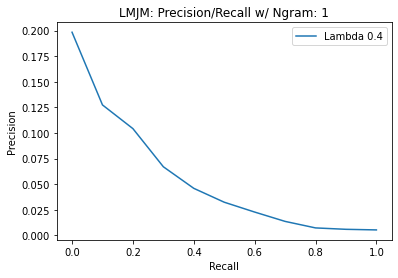

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [24]:
def LMJMSection(section, nGram, nameSection):
    allP10s,allMrr, allNdcg5, allAp, allRecalls = ([] for i in range(5))
    avg_precision_11pointTesteUni = np.zeros(11)

    vectorizerUnigramaTeste = CountVectorizer(ngram_range=(nGram,nGram), analyzer = "word", stop_words = None)
    vectorizerUnigramaTeste.fit(section)
    YUniTeste = vectorizerUnigramaTeste.transform(section)

    termProbabilityAllCorpus, termProbabilityDocument = calculateLMJMValues(YUniTeste)
    melhorLambdaUnigramas = 0.4
    listaDocscores = []
    #So para as queries de teste
    for caseid in casesTeste:
        queryUniTeste = casesTeste[caseid]
        query_CountUniTeste = vectorizerUnigramaTeste.transform([queryUniTeste]).toarray()

        PqDc = ((melhorLambdaUnigramas * termProbabilityDocument) + ((1-melhorLambdaUnigramas)*termProbabilityAllCorpus)) + 1e-30
        #Calcular os scores para cada ensaio tendo em conta a querie atual
        doc_scores = np.log(PqDc)*query_CountUniTeste.T
        
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)
        listaDocscores.append(results_ord)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        allP10s.append(p10)
        allMrr.append(mrr)
        allNdcg5.append(ndcg5)
        allAp.append(ap)
        allRecalls.append(recall)

        [precision_11pointTesteUni, recall_11pointTesteUni, total_relv_ret] = eval.evalPR(results_ord, caseid)
        if (np.shape(recall_11pointTesteUni) != (0,)):
            avg_precision_11pointTesteUni = avg_precision_11pointTesteUni + precision_11pointTesteUni

    averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(casesTeste), allRecalls)

    printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)

    #Plot precision-recall com queries de teste e unigramas
    makePrecisionRecall(recall_11pointTesteUni, avg_precision_11pointTesteUni, len(casesTeste), melhorLambdaUnigramas, "LMJM: Precision/Recall w/ Ngram: 1")

    ## Escrever docscores para ficheiro
    pickle.dump(listaDocscores, open("LMJM_" + nameSection + "_docscores.bin", "wb" ) ) 
    #talvez mudar o return caso queiramos as metricas sem ser os docscores
    return results_ord

LMJMSection(docBriefSummary, 1, "docBriefSummary")
LMJMSection(docsTitle, 1, "docsTitle")
LMJMSection(docsDetailed_Description, 1, "docDetDescription")
LMJMSection(docCriteria, 1, "docCriteria")

## VECTOR SPACE MODEL (ngrama = 1)

No handles with labels found to put in legend.


P10 = 0.095
MRR = 0.005085057471264367
NDCG5 = 0.09685284857763819
MAP = 0.07184800362407424
Recall = 0.9833333333333333


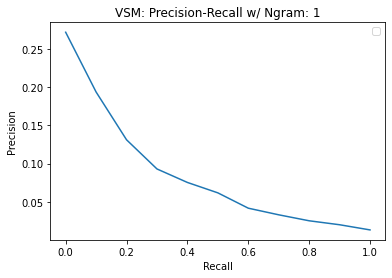

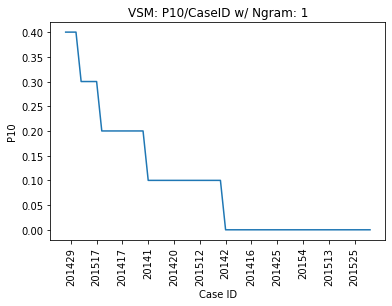

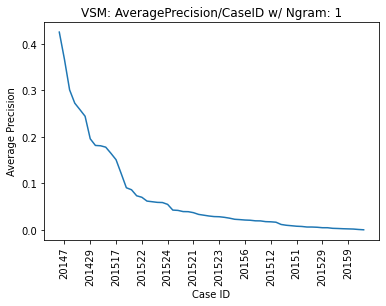

In [15]:
def VSMSection(section, nGram, nameSection):
    common_stop_words = {"is", "the", "an", "a", "to", "and", "be", "been", "that", "this", "i", "than", "patient", "am", "health", "sick", "clinical"}

    vectorizerVSM = TfidfVectorizer(ngram_range=(nGram,nGram), analyzer = "word", stop_words = None)
    vectorizerVSM.fit(section)
    transformDocsVSM = vectorizerVSM.transform(section)

    allP10s,allMrr, allNdcg5, allAp, allRecall = ([] for i in range(5))
    avg_precision_11pointVSMUni = np.zeros(11)
    dictCaseIDP10 = dict()
    dictCaseAP = dict()
    listaDocscores = []
    for caseid in cases:
        queryTFIDF = cases[caseid]
        query_CountVSM = vectorizerVSM.transform([queryTFIDF])
        doc_scoresVSM = 1 - pairwise_distances(transformDocsVSM, query_CountVSM, metric="cosine")
    
        #Metricas
        results = pd.DataFrame(list(zip(ids, doc_scoresVSM)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)
        listaDocscores.append(results_ord)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        #Para fazer as medias dos prints
        allP10s.append(p10)
        allMrr.append(mrr)
        allNdcg5.append(ndcg5)
        allAp.append(ap)
        allRecall.append(recall)

        #Para fazer plot de P10-CaseId e AP-Case id (os pacientes com mais matches)
        dictCaseIDP10[caseid] = p10
        dictCaseAP[caseid] = ap

        [precision_11pointVSMUni, recall_11pointVSMUni, total_relv_ret] = eval.evalPR(results_ord, caseid)
        if (np.shape(recall_11pointVSMUni) != (0,)):
            avg_precision_11pointVSMUni = avg_precision_11pointVSMUni + precision_11pointVSMUni

    averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(cases), allRecall)
    printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)
    makePrecisionRecall(recall_11pointVSMUni, avg_precision_11pointVSMUni, len(cases), None, "VSM: Precision-Recall w/ Ngram: 1")
    makeIDP10Graphic(dictCaseIDP10, "VSM: P10/CaseID w/ Ngram: 1", 60)
    makeIDAPGraphic(dictCaseAP, "VSM: AveragePrecision/CaseID w/ Ngram: 1", 60)

    ## Escrever docscores para ficheiro
    pickle.dump(listaDocscores, open("LMJM_" + nameSection + "_docscores.bin", "wb" ) ) 
    #talvez mudar o return caso queiramos as metricas sem ser os docscores
    return results_ord

LMJMSection(docBriefSummary, 1, "docBriefSummary")
LMJMSection(docsTitle, 1, "docsTitle")
LMJMSection(docsDetailed_Description, 1, "docDetDescription")
LMJMSection(docCriteria, 1, "docCriteria")

